# HR Analytics

## Task 2: Predicting Facilitator Performance for Connected at Youth Impact

----

In [12]:
# import necessary libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model, tree, ensemble
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.svm import SVR

In [13]:
# global file path
path_application = '/Users/michaelfive/Dropbox/R&I/18_Facilitator_Database/02_Data_Analysis/100_HR-Analytics/01_connected_data/application_data/'

# import the cleaned and imputed dataset
dat = pd.read_csv(path_application + 'cleaned/application_hired_mi.csv')

In [3]:
dat

,app_data_source,loc_region,return_to_yp,score_total,dem_gender,dem_age,edu_qual_highest,edu_qual_highest_year,emp_yes,emp_org_type,...,emp_currently,exp_w_child,exp_length_teacher,exp_length_school,exp_length_employee,exp_length_volunteer,interest_w_child,prac_scenario_volunt,prac_scenario_noshow,level_gains
0,T1 2020,Kgatleng,Yes,20.00,Female,25,Certificate,2019,Yes,Education,...,Yes,Yes,36,66,17,28,4,1,Planning together with fellow facilitators,1.234042
1,T1 2020,North East,No,20.00,Female,25,Certificate,2019,Yes,Education,...,Yes,Yes,36,66,24,24,4,1,Planning together with fellow facilitators,1.468085
2,T1 2020,South East,No,19.50,Female,23,Certificate,2018,Yes,Education,...,No,Yes,3,66,3,36,4,1,Planning together with fellow facilitators,0.481482
3,T1 2020,North West,No,19.50,Female,23,Certificate,2018,Yes,Education,...,No,Yes,3,66,3,36,4,1,Planning together with fellow facilitators,1.468085
4,T1 2020,Kgatleng,No,19.00,Female,23,Diploma,2019,Yes,Education,...,No,Yes,3,5,17,36,4,1,Planning together with fellow facilitators,0.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,T3 2023,Central,No,16.00,Female,24,Secondary School,2016,Yes,Education,...,No,Yes,3,9,3,28,3,1,Plan individually,0.923077
220,T3 2023,North East,Yes,15.50,Male,22,Secondary School,2020,No,"Health care, social assistance, nonprofit",...,No,Yes,3,1,2,3,4,1,Plan individually,0.923077
221,T3 2023,Kgatleng,No,14.75,Female,0,Bachelors Degree,2022,No,Other,...,No,Yes,3,24,3,7,1,1,Plan individually,0.595745
222,T3 2023,North East,No,14.75,Female,18,Secondary School,2022,Yes,Arts and entertainment,...,No,Yes,3,3,3,12,3,1,Plan individually,0.980000


In [14]:
# split the data into training and testing sets
X = dat.drop(['level_gains'], axis=1)
y = dat['level_gains']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state = 1234)

In [15]:
# summary statistics of the outcome variable
print(y_train.describe())
print(y_test.describe())

count    179.000000
mean       0.821941
std        0.346365
min       -0.071429
25%        0.538462
50%        0.923077
75%        1.064516
max        1.468085
Name: level_gains, dtype: float64
count    45.000000
mean      0.900248
std       0.294671
min      -0.071429
25%       0.846154
50%       0.980000
75%       1.000000
max       1.468085
Name: level_gains, dtype: float64


# Modeling

## Preprocessing Pipeline

In [16]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 10 numerical features: 

['score_total', 'dem_age', 'edu_qual_highest_year', 'emp_duration', 'exp_length_teacher', 'exp_length_school', 'exp_length_employee', 'exp_length_volunteer', 'interest_w_child', 'prac_scenario_volunt']


In [17]:
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 10 categorical features: 

['app_data_source', 'loc_region', 'return_to_yp', 'dem_gender', 'edu_qual_highest', 'emp_yes', 'emp_org_type', 'emp_currently', 'exp_w_child', 'prac_scenario_noshow']


In [18]:
# Create pipeline for numeric and categorical variables separately
numeric_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler()) # standardizing
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # one hot encoding
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

## Linear Regression (OLS, lasso, ridge, and elastic net regression)

In [37]:
# Define a pipeline that uses the preprocessor and a placeholder for the model
lm_pipe = Pipeline([
    ('preprocess', full_processor),
    ('model', linear_model.LinearRegression())  # This will be replaced by each model in the grid search
])

# Define the parameter grid
lm_param_grid = [
    {
        'model': [linear_model.LinearRegression()],
    },
    {
        'model': [linear_model.Ridge()],
        'model__alpha': np.logspace(-3, 3, 7)
    },
    {
        'model': [linear_model.Lasso()],
        'model__alpha': np.logspace(-3, 3, 7)
    },
    {
        'model': [linear_model.ElasticNet()],
        'model__alpha': np.logspace(-3, 3, 7),
        'model__l1_ratio': np.linspace(0.1, 0.9, 9)  # Mix ratio for L1 and L2. 1.0 is Lasso and 0.0 is Ridge.
    }
]

# Now perform the grid search
lm_search = GridSearchCV(
    lm_pipe,
    lm_param_grid,
    cv=model_selection.KFold(n_splits=10, shuffle=True, random_state=1),
    scoring="neg_mean_squared_error",
    verbose=True
)

In [38]:
# Train the model using the training sets
lm_fit = lm_search.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_lm = lm_fit.predict(X_test)

Fitting 10 folds for each of 78 candidates, totalling 780 fits


In [39]:
print("The root mean squared error for linear regression （including lasso, ridge, and elastic net） is: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_lm)))

The root mean squared error for linear regression （including lasso, ridge, and elastic net） is: 0.24


# Tree Model

In [40]:
# Pipeline
tree_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', tree.DecisionTreeRegressor(random_state = 1234))
])

# Grid search
tree_search = GridSearchCV(
    tree_pipe,
    {'model__max_depth': np.arange(2,12,2)},
    cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1), 
    scoring="neg_mean_squared_error",
    verbose=False
)

In [41]:
# Train the model using the training sets
tree_fit = tree_search.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_tree = tree_fit.predict(X_test)

In [47]:
print("The root mean squared error for tree model is: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_tree)))

The root mean squared error for tree model is: 0.31


# Random Forest

In [170]:
# Pipeline
rf_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', ensemble.RandomForestRegressor(random_state = 1234))
])

# Adjustments for randomized search CV for regression
rf_search = RandomizedSearchCV(
    rf_pipe,
    {
        'model__n_estimators': [20, 50, 100],
        'model__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'model__max_features': ['sqrt'],
        'model__min_samples_leaf': [1, 2, 4],
        'model__min_samples_split': [2, 5, 10],
        'model__bootstrap': [True, False]
    },
    cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
    scoring="neg_mean_squared_error",
    random_state=12,
    verbose=True
)

In [171]:
# Train the model using the training sets
rf_fit = rf_search.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_rf = rf_fit.predict(X_test)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


In [172]:
print("The root mean squared error for random forest model is: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_rf)))

The root mean squared error for random forest model is: 0.28


# XGBoost

In [187]:
# Pipeline for regression
xgb_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', xgb.XGBRegressor(random_state = 1, 
                               n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8))
])

# Parameter grid for XGBoost regression
param_grid = {
    'model__n_estimators': [20, 50, 100],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'model__max_depth': [3, 5, 7, 10],
    'model__colsample_bytree': [0.5, 0.7, 1],
    'model__gamma': [0, 0.1, 0.2]
}

# Adjustments for randomized search CV for regression
xgb_search = RandomizedSearchCV(
    xgb_pipe,
    param_grid,
    cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
    scoring="neg_mean_squared_error",
    random_state=1,
    verbose=True
)

In [188]:
# Train the model using the training sets
xgb_fit = xgb_search.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_xgb = xgb_fit.predict(X_test)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


In [189]:
print("The root mean squared error for XGBoost model is: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

The root mean squared error for XGBoost model is: 0.24


# Support Vector Machine

In [150]:
# Define a pipeline that uses the preprocessor and the SVM model
svm_pipe = Pipeline([
    ('preprocess', full_processor),
    ('model', SVR())  # This will be replaced by the best parameters in the grid search
])

# Define the parameter grid
svm_param_grid = {
    'model__kernel': ['linear', 'rbf'],
    'model__C': [0.1, 1, 10],
    'model__epsilon': [0.1, 0.2, 0.3]
}

# Now perform the grid search
svm_search = GridSearchCV(
    svm_pipe,
    svm_param_grid,
    cv=model_selection.KFold(n_splits=10, shuffle=True, random_state=1),
    scoring="neg_mean_squared_error",
    verbose=True
)

In [151]:
# Train the model using the training sets
svm_fit = svm_search.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_svm = svm_fit.predict(X_test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


In [176]:
print("The root mean squared error for SVM model is: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_svm)))

The root mean squared error for SVM model is: 0.25


# Interpreting the best model (XGBoost)

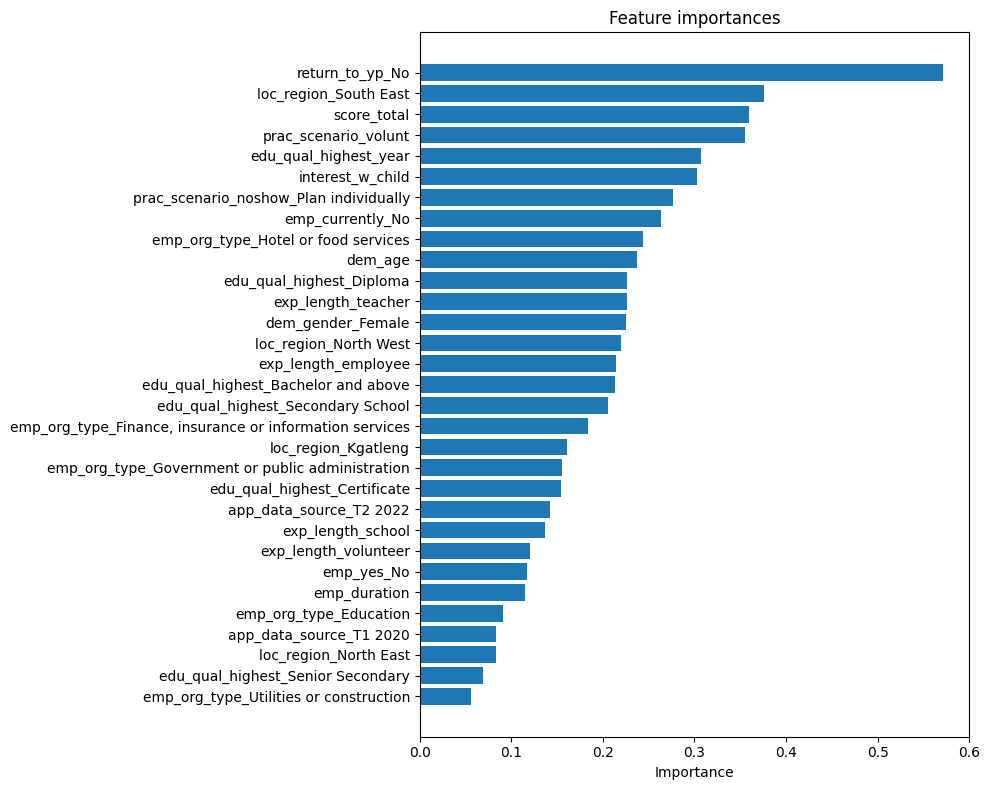

In [23]:
# Additional code for feature importances
# Extract the best estimator
best_model = xgb_fit.best_estimator_.named_steps['model']

# Get feature importance
importance = best_model.get_booster().get_score(importance_type='gain')

# Get feature names after transformation
# For numeric features, the names stay the same
numeric_feature_names = numerical_features

# For categorical features, get out the one-hot encoded column names
ohe = xgb_fit.best_estimator_.named_steps['preprocess'].named_transformers_['category'].named_steps['one-hot']
categorical_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine the two lists
feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Now you can create the fmap using these feature names
fmap = {f'f{i}': col for i, col in enumerate(feature_names)}

# Replace feature names in the importance dict
importance = {fmap[k]: v for k, v in importance.items()}

# Convert the importance to a DataFrame for easier plotting
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10,8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to place the most important features at the top
plt.xlabel('Importance')
plt.title('Feature importances')
plt.tight_layout()
plt.savefig('feature_importances_performance.png')
plt.show()


# Interpreting SVM

Support Vector Machines (SVM) in their classic form are not as interpretable as some other models, such as linear regression or decision trees. However, when the SVM uses a linear kernel (kernel='linear'), the SVM does provide weights (or coefficients) for each feature, similar to a linear regression model. These weights can give us an idea of the importance of each feature, at least in the context of the linear SVM.

For a linear SVM, each weight corresponds to a feature. The magnitude of the weight indicates the importance of that feature in determining the decision boundary, and the sign of the weight (positive or negative) indicates the direction of the relationship.

**It does seem that the composite score is the best predictor of facilitator's performance. We need to be cautious when interpreting other coefficients because their magnitudes are not so large, and sometimes the sign is contrary to what we believe and it may be difficult to understand why from a machine learning perspective.**

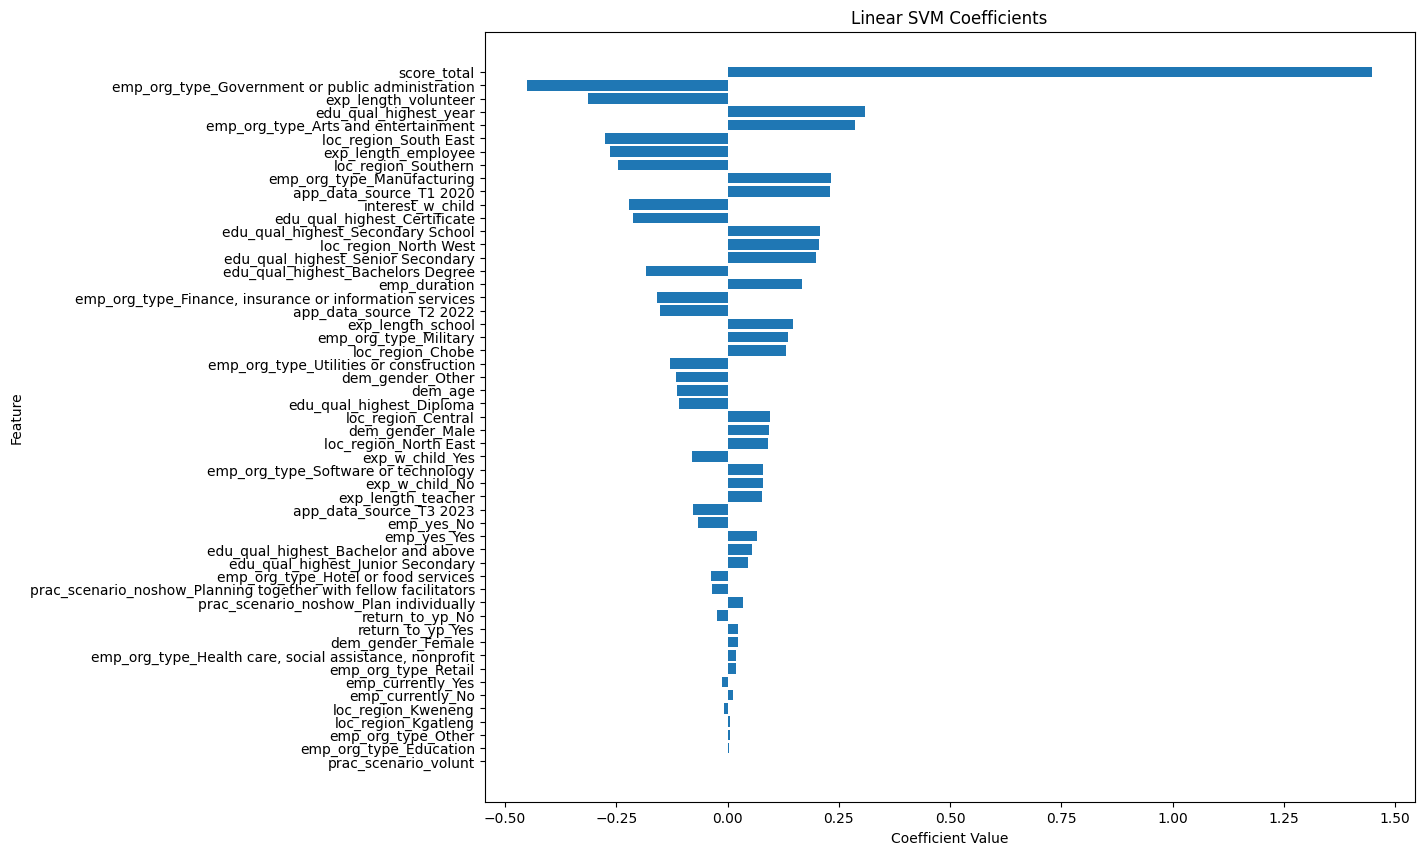

In [148]:
# Using a linear kernel for SVM
best_svm = svm_fit.best_estimator_.named_steps['model']
if best_svm.kernel == 'linear':
    coef = best_svm.coef_[0]  # Extract coefficients

    # Sort coefficients by magnitude
    sorted_indices = np.argsort(np.abs(coef))[::-1]  # Sort in descending order
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_coef = coef[sorted_indices]

    # Filter out zero coefficients for clarity
    non_zero_indices = np.where(sorted_coef != 0)
    sorted_features = sorted_features[non_zero_indices]
    sorted_coef = sorted_coef[non_zero_indices]

    # Plot
    plt.figure(figsize=(12, 10))
    plt.barh(sorted_features, sorted_coef, align='center')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Linear SVM Coefficients')
    plt.gca().invert_yaxis()  # Display the largest coefficients at the top
    plt.show()
else:
    print("Cannot interpret feature weights for non-linear SVM.")


# Interpreting lasso regression

In [70]:
best_score = lm_search.best_score_
print(f"The best score (negative MSE) is: {best_score}")

best_params = lm_search.best_params_
print("The best hyperparameters are:", best_params)

The best score (negative MSE) is: -0.0643340223622663
The best hyperparameters are: {'model': Lasso(alpha=0.001), 'model__alpha': 0.001}


In [132]:
# get one-hot encoded variable names
feature_name_str_raw = list(full_processor.transformers_[1][2])
transformer_str = full_processor.transformers_[1][1]
feature_name_str = list(transformer_str.get_feature_names_out(feature_name_str_raw))

# get numeric variable names
feature_name_num = list(full_processor.transformers_[0][2])

# combine the list of names
feature_names = feature_name_num + feature_name_str

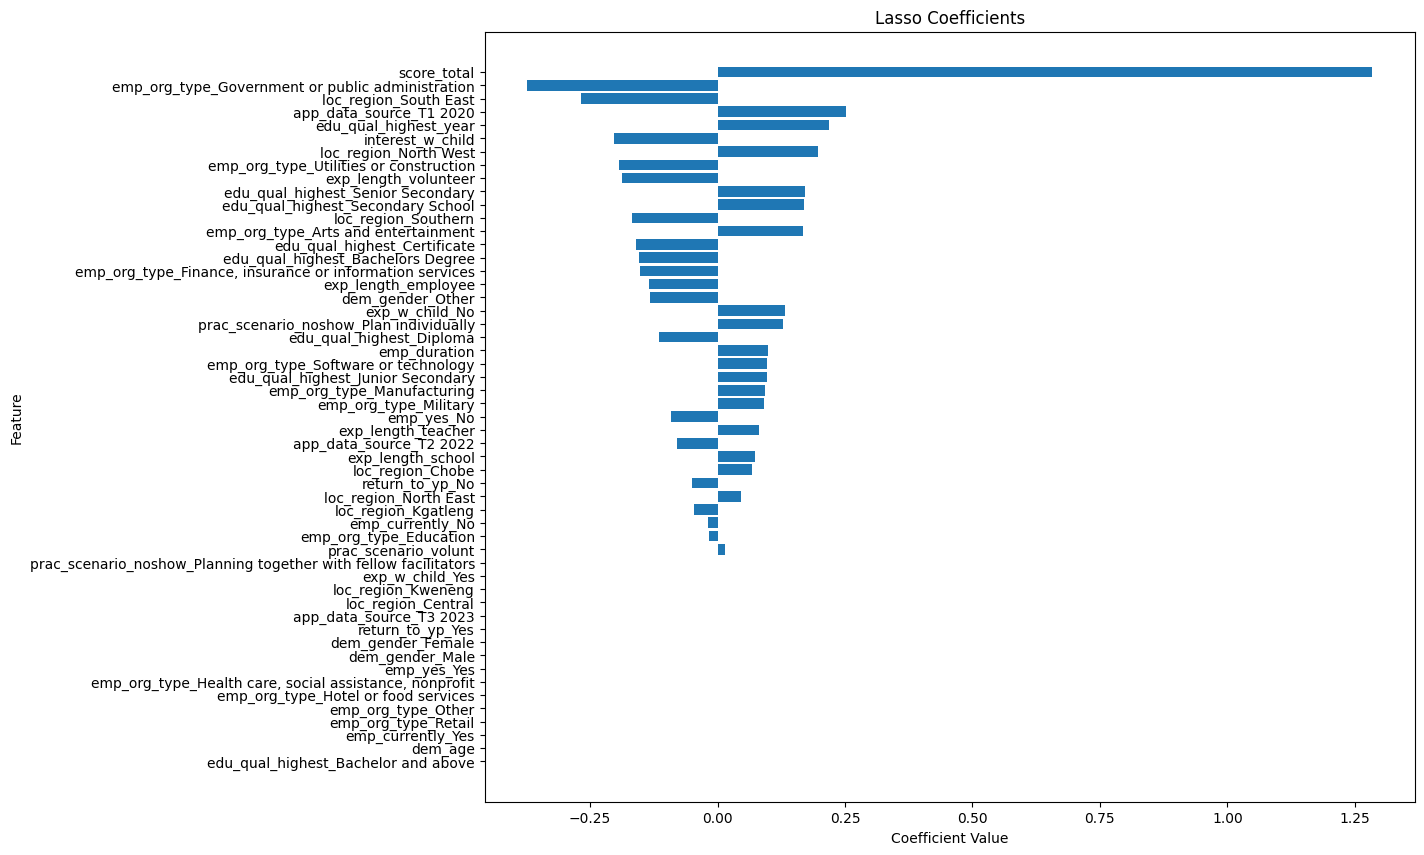

In [139]:
# Extract coefficients from the best Lasso model
coef = best_lasso.coef_

# Sort coefficients by magnitude
sorted_indices = np.argsort(np.abs(coef))[::-1]  # Sort in descending order
sorted_features = np.array(feature_names)[sorted_indices]
sorted_coef = coef[sorted_indices]

# Plot
plt.figure(figsize=(12, 10))
plt.barh(sorted_features, sorted_coef, align='center')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Lasso Coefficients')
plt.gca().invert_yaxis()  # Display the largest coefficients at the top
plt.show()


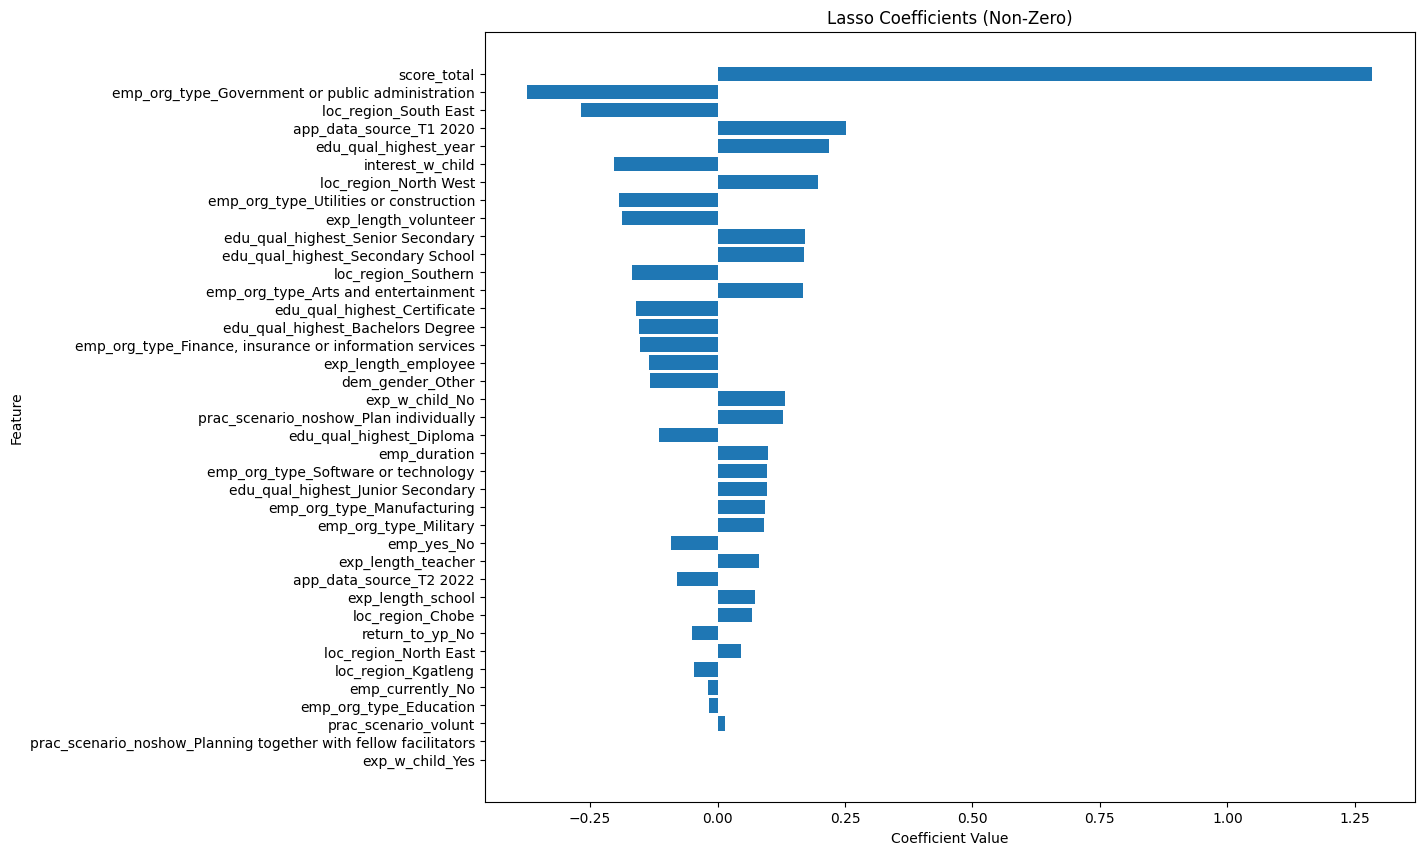

In [140]:
# Filter out features where the coefficient is zero
non_zero_indices = np.where(coef != 0)[0]

# Only consider non-zero coefficients for sorting and plotting
non_zero_coefs = coef[non_zero_indices]
non_zero_features = np.array(final_feature_names)[non_zero_indices]

# Sort non-zero coefficients by magnitude
sorted_indices = np.argsort(np.abs(non_zero_coefs))[::-1]  # Sort in descending order
sorted_features = non_zero_features[sorted_indices]
sorted_coef = non_zero_coefs[sorted_indices]

# Plot
plt.figure(figsize=(12, 10))
plt.barh(sorted_features, sorted_coef, align='center')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Lasso Coefficients (Non-Zero)')
plt.gca().invert_yaxis()  # Display the largest coefficients at the top
plt.show()


# Save model objects for future use

In [153]:
# Import the base class for scikit-learn estimators to check the types of your objects
from sklearn.base import BaseEstimator

# Get a dictionary of all global objects
global_objects = globals()

# Filter this dictionary to get only the model objects
model_objects = {name: obj for name, obj in global_objects.items() if isinstance(obj, BaseEstimator)}

# Print the names of the model objects
for name in model_objects.keys():
    print(name)

numeric_pipeline
categorical_pipeline
full_processor
linear_pipe
linear_search
lm_pipe
lm_search
_20
lm_fit
_22
tree_pipe
tree_search
tree_fit
rf_pipe
rf_search
rf_fit
xgb_pipe
xgb_search
xgb_fit
best_lasso
_74
_79
_81
_82
_83
_84
transformer
_101
_104
_109
_112
_113
transformer_str
_126
_128
svm_pipe
svm_search
svm_fit
best_svm


In [191]:
import joblib

# Save the best model (xgboost)
joblib.dump(xgb_fit, '/Users/michaelfive/Desktop/R Directory/Youth Impact/yp_hr_analytics/models/hired_xgb_fit.pkl')

['/Users/michaelfive/Desktop/R Directory/Youth Impact/yp_hr_analytics/models/hired_xgb_fit.pkl']

# Predict future facilitators' performance

In [155]:
# Manually specific a new data frame with one new entry of data
temp_vars = {
    'app_data_source': "T2 2022",
    'loc_region': 'South East',
    'return_to_yp': 'Yes',
    'score_total': 27,
    'dem_gender': 'Female',
    'dem_age': 25,
    'edu_qual_highest': 'Bachelor and above',
    'edu_qual_highest_year': 2020,
    'emp_yes': 'Yes',
    'emp_org_type': 'Health care, social assistance, nonprofit',
    'emp_duration': 45.6,
    'emp_currently': 'No',
    'exp_w_child': 'Yes',
    'exp_length_teacher': 9.0,
    'exp_length_school': 16.8,
    'exp_length_employee': 12.0,
    'exp_length_volunteer': 6.0,
    'interest_w_child': 4,
    'prac_scenario_volunt': 1,
    'prac_scenario_noshow': 'Planning together with fellow facilitators'
}

temp_df = pd.DataFrame([temp_vars])


In [160]:
# Retrieve the best estimator from the RandomizedSearchCV
best_model = svm_fit.best_estimator_

# Extract the preprocessor from the best estimator
preprocessor = best_model.named_steps['preprocess']

# Preprocess the single row using the fitted preprocessor
preprocessed_row = preprocessor.transform(temp_df)

# Get the predicted probabilities for the preprocessed row
predicted_value = best_model.named_steps['model'].predict(preprocessed_row)

# Predict the hiring probabilities for this new potential hire
print(f"Predicted average levels gain among students for this new facilitator: {predicted_value[0]:.2f}")

Predicted average levels gain among students for this new facilitator: 1.24
